In [1]:

import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [2]:
BASE_DIR = 'E:\lava'
WORKING_DIR = 'E:\lava'

In [3]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
batch_size = 32
features = {}
directory = os.path.join(BASE_DIR, 'img')

# Function to preprocess and extract features for a batch of images
def process_batch(image_names):
    batch_features = {}
    for img_name in image_names:
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)#here we are converting the image to pixels 
        image = preprocess_input(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]# For getting the image id 
        batch_features[image_id] = feature
    return batch_features

# Process images in batches
all_image_names = os.listdir(directory)
for i in tqdm(range(0, len(all_image_names), batch_size)):
    batch_image_names = all_image_names[i:i+batch_size]
    batch_features = process_batch(batch_image_names)
    features.update(batch_features)

    # Save features to disk after processing each batch
    with open('features.pkl', 'wb') as f:
        pickle.dump(features, f)

# Save remaining features
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'cp.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/249 [00:00<?, ?it/s]

In [9]:
len(mapping)


50

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

249

In [16]:
all_captions[:10]

['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size


514

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

23

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

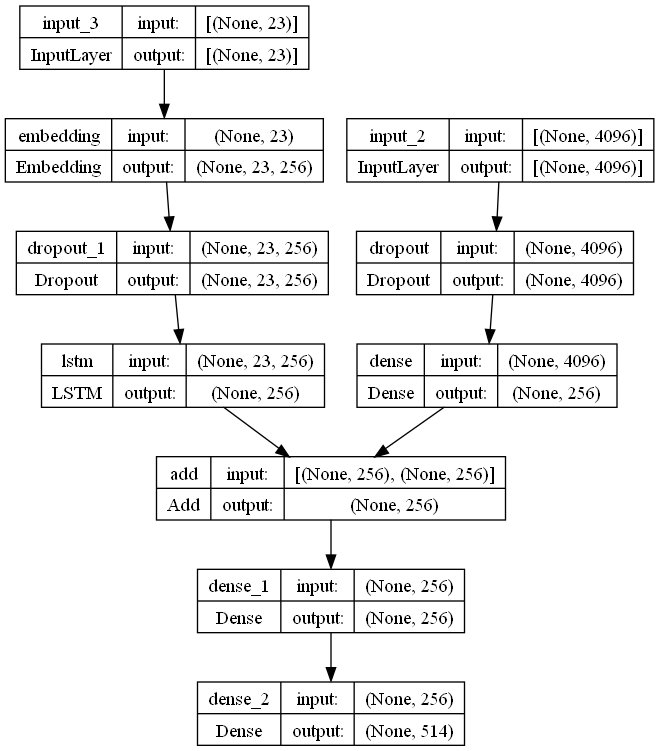

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [23]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 3.6501


In [24]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/5 [00:00<?, ?it/s]

BLEU-1: 0.279120
BLEU-2: 0.083617


c:\Users\Kushagra pathak\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Kushagra pathak\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Predicted---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    #y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    #print('--------------------Predicted--------------------')
    #print(y_pred)
    plt.imshow(image)

---------------------Predicted---------------------
startseq boy takes jump on his skateboard while another boy with skateboard watches endseq
startseq child is performing skateboard trick while another child with skateboard leans on wall endseq
startseq little boy skateboarder is doing trick on his board while another young skateboarder watches endseq
startseq young boy skateboarder jumping on platform on skateboard endseq
startseq two skateboarders endseq


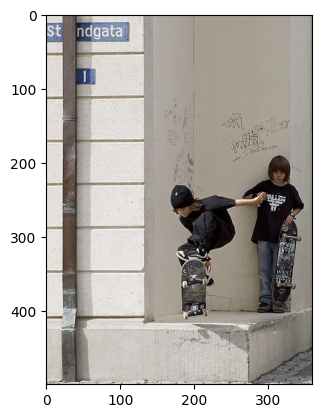

In [29]:
generate_caption("1052358063_eae6744153.jpg")

---------------------Predicted---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq


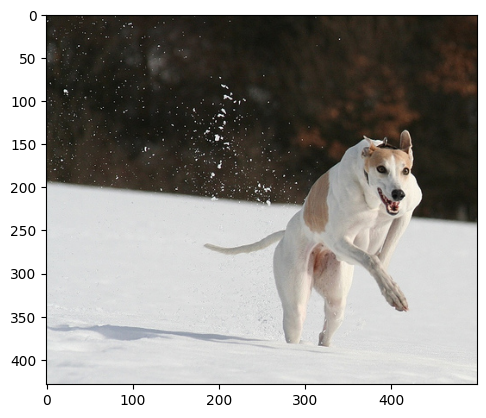

In [31]:
generate_caption("101654506_8eb26cfb60.jpg")

---------------------Predicted---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq


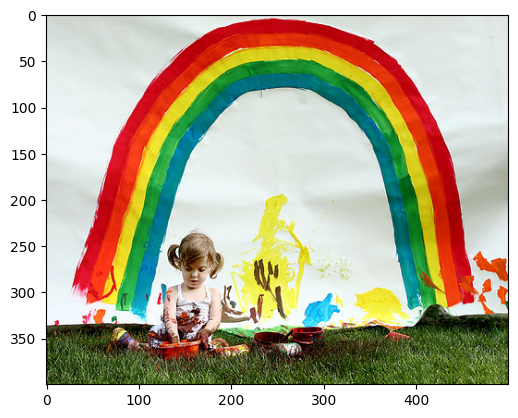

In [32]:
generate_caption("1002674143_1b742ab4b8.jpg")


---------------------Predicted---------------------
startseq boy in his blue swim shorts at the beach endseq
startseq boy smiles for the camera at beach endseq
startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq
startseq children playing on the beach endseq
startseq the boy is playing on the shore of an ocean endseq


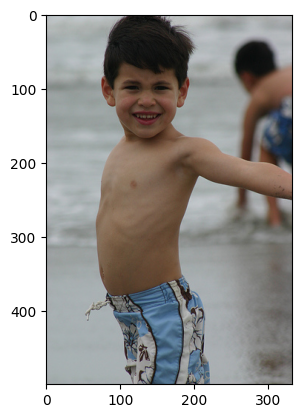

In [31]:
generate_caption("106490881_5a2dd9b7bd.jpg")
